# Visualize _starlet_ transform

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LightModel.Profiles.starlets import SLIT_Starlets
import lenstronomy.Util.util as lenstro_util
from slitronomy.Util.plot_util import nice_colorbar

import source_util

%matplotlib inline

In [2]:
cmap_flux = copy.deepcopy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)

v_min, v_max = 1e-3, None

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  


In [3]:
def B3slpline(x):
    return 1./12 * ( np.abs(x-2)**3 - 4*np.abs(x-1)**3 + 6*np.abs(x)**3 - 4*np.abs(x+1)**3 + np.abs(x+2)**3 )

## Generate source image

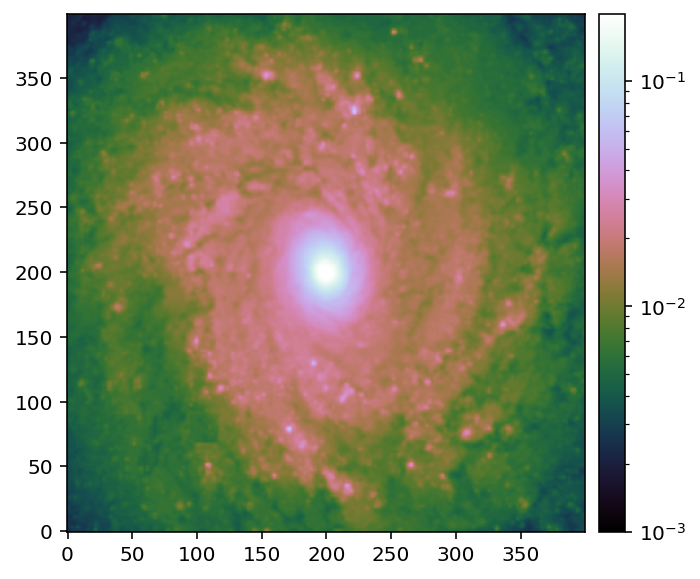

In [4]:
num_pix = 400
delta_pix = 0.01
ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, transform_pix2angle, _ \
    = lenstro_util.make_grid_with_coordtransform(num_pix, delta_pix, subgrid_res=1, inverse=False)

ra_source, dec_source, amp_source = 0, 0, 2e3
source_model_list, kwargs_source = source_util.prepare_highres_source(ra_source, dec_source, 
                                                                      galaxy_name='NGC3982', 
                                                                      amp=amp_source)

# set the scale of the galaxy so that it fills the image
kwargs_source[0]['scale'] = 0.02

# generate the image
source_model_class = LightModel(source_model_list)
source_sim = source_model_class.surface_brightness(ra_grid, dec_grid, kwargs_source)
source_sim = lenstro_util.array2image(source_sim) * delta_pix**2  # flux units
if v_max is None:
    v_max = source_sim.max()

plt.figure(figsize=(5, 5))
im = plt.imshow(source_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(v_min, v_max))
nice_colorbar(im)
plt.show()

### Decompose image into starlet coefficients

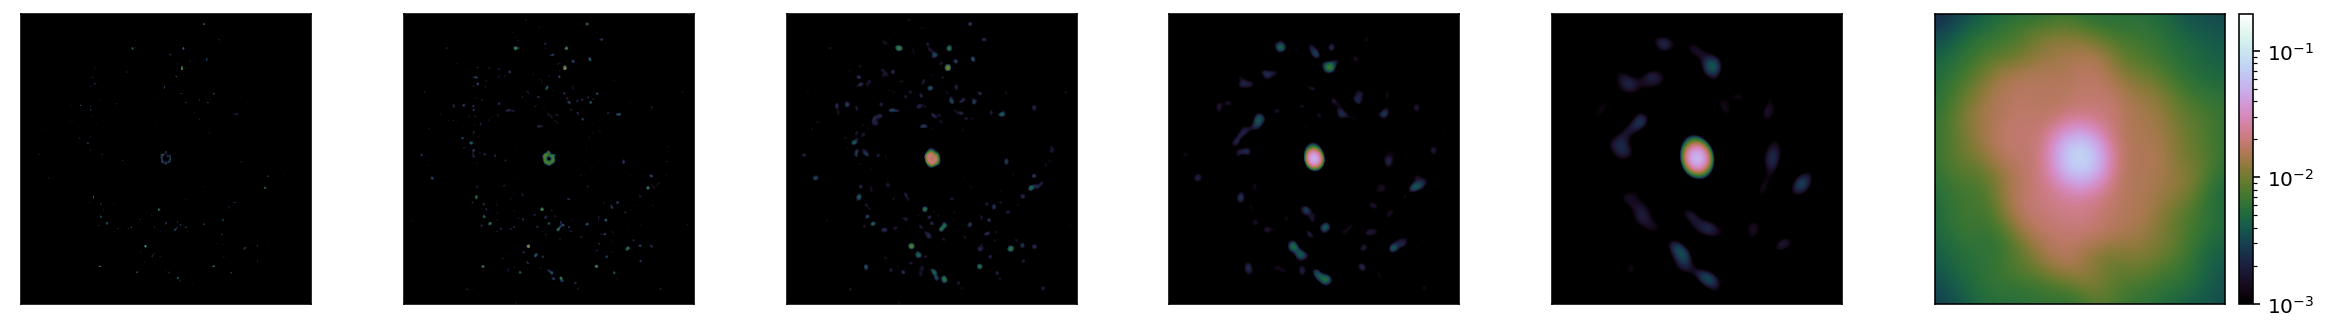

In [5]:
n_scales = 6
starlet_profile = SLIT_Starlets(thread_count=8, fast_inverse=True, second_gen=False)
coeffs = starlet_profile.decomposition_2d(source_sim, n_scales=n_scales)

fig, axes = plt.subplots(1, n_scales, figsize=(20, 4))
for i in range(n_scales):
    ax = axes[i]
    im = ax.imshow(coeffs[i, :, :], origin='lower', cmap=cmap_flux, norm=LogNorm(v_min, v_max))
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    if i == n_scales-1:
        nice_colorbar(im)
    else:
        nice_colorbar(im, invisible=True)
plt.show()

### Reconcstruct image from starlet coefficients

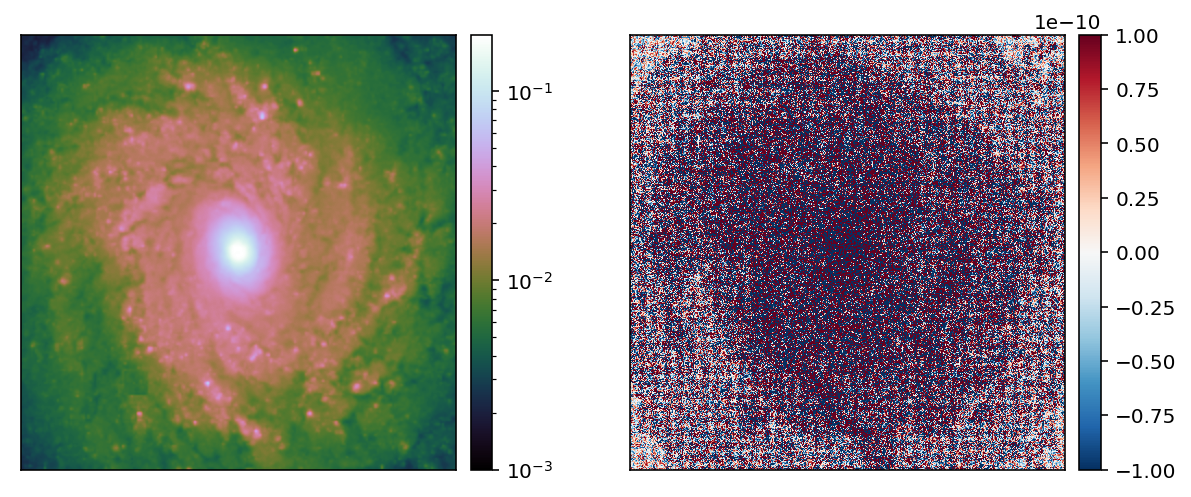

In [6]:
n_pixels = source_sim.size
source_recon = starlet_profile.function_2d(coeffs, n_scales=n_scales, n_pixels=n_pixels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
im = ax.imshow(source_recon, origin='lower', cmap=cmap_flux, norm=LogNorm(v_min, v_max))
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
nice_colorbar(im)
ax = axes[1]
im = ax.imshow(source_sim-source_recon, origin='lower', cmap='RdBu_r', vmin=-1e-10, vmax=1e-10)
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
nice_colorbar(im)
plt.show()

## Summary plot

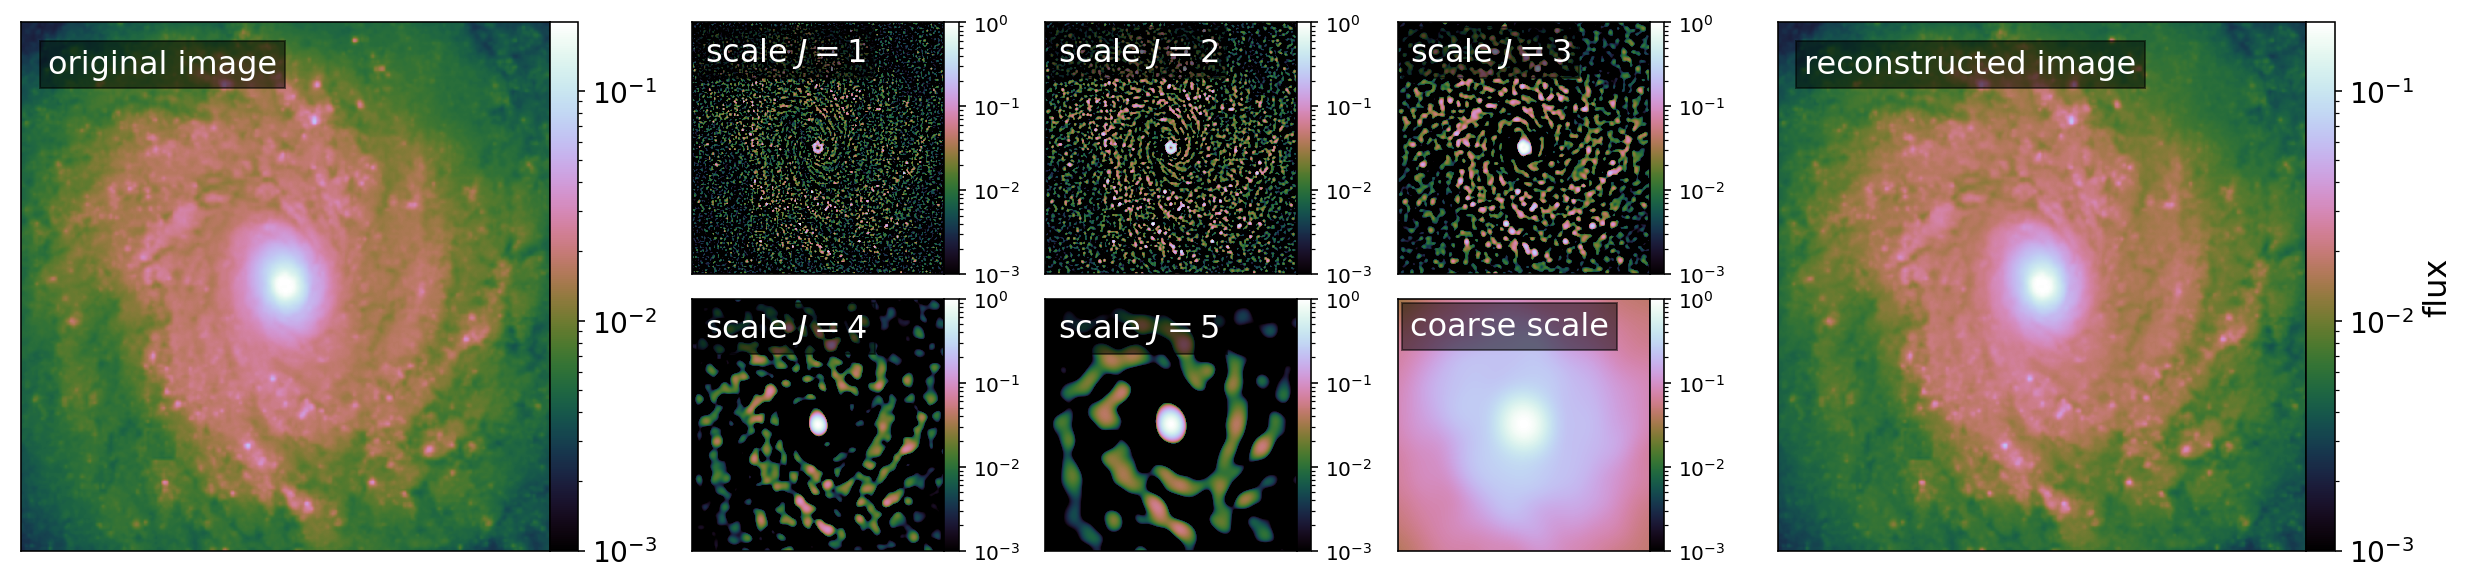

In [7]:
def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})


fig = plt.figure(figsize=(17, 3.8), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2+n_scales//2+2, wspace=0, hspace=0)
#print(gs)

# original image
ax = fig.add_subplot(gs[:, :2])
add_title_box(ax, "original image")
im = ax.imshow(source_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(v_min, v_max))
cb = nice_colorbar(im, invisible=False, pad=0, size=0.2, fontsize=16)
cb.ax.tick_params(labelsize=14)
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

# starlet decomposition scales
scale_idx = 1
for j in range(2):
    for i in range(n_scales//2):
        #print(j, 2+i)
        ax = fig.add_subplot(gs[j, 2+i])
        if scale_idx < n_scales:
            title = "scale $J={}$".format(int(scale_idx))
        else:
            title = "coarse scale"
        add_title_box(ax, title)
        im = ax.imshow(coeffs[scale_idx-1, :, :]/coeffs[scale_idx-1, :, :].max(), 
                       origin='lower', cmap=cmap_flux, norm=LogNorm(v_min))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        cb = nice_colorbar(im, invisible=False, pad=0, size=0.1)
        cb.ax.tick_params(labelsize=10)
        scale_idx += 1

# reconstructed image
ax = fig.add_subplot(gs[:, 5:])
add_title_box(ax, "reconstructed image")
im = ax.imshow(source_recon, origin='lower', cmap=cmap_flux, norm=LogNorm(v_min, v_max))
cb = nice_colorbar(im, invisible=False, pad=0, size=0.2, label="flux", fontsize=16)
cb.ax.tick_params(labelsize=14)
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

plt.show()

In [8]:
# save the figure
fig_name = 'starlet_transform.pdf'
#fig.savefig(os.path.join('figures', fig_name), dpi=100, bbox_inches='tight')

## Dynamic range: shapelets _vs_ starlets

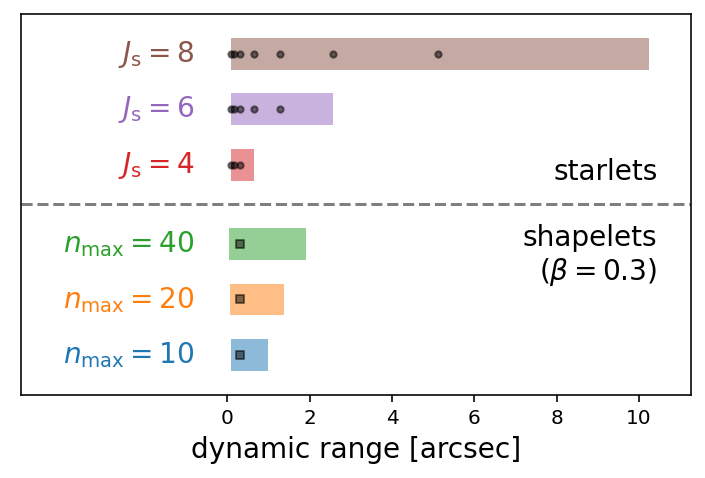

In [155]:
num_pix, delta_pix = 100, 0.08
region_width, region_alpha = 0.1, 0.5

# shapelets settings
n_max_list = [10, 20, 40]
beta = 0.3  # arcsec

# starlets settings
J_s_list = [4, 6, 8]

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlabel("dynamic range [arcsec]", fontsize=14)
ax.axhline(0.5, linestyle='--', color='black', alpha=0.5)
ax.text(0.95, 0.55, "starlets", transform=ax.transAxes, ha='right', va='bottom', fontsize=14)
ax.text(0.95, 0.45, r"shapelets"+"\n"+r"$(\beta={})$".format(beta), transform=ax.transAxes, ha='right', va='top', fontsize=14)
for i, n_max in enumerate(n_max_list):
    shapelets_scale_min = beta / np.sqrt(1 + n_max)
    shapelets_scale_max = beta * np.sqrt(1 + n_max)
    y = i/(len(n_max_list)-1)*0.35 + 0.025
    y1, y2 = y-region_width/2, y+region_width/2
    c = ax.fill_between([shapelets_scale_min, shapelets_scale_max], y1=[y1, y1], y2=[y2, y2], alpha=region_alpha)
    ax.scatter([beta], [y], c='black', s=20, marker='s', alpha=0.5)
    color = copy.copy(c.get_facecolor()[0]); color[-1] = 1
    ax.text(-0.8, y, r"$n_{\rm max}="+r"{}$".format(n_max), color=color, ha='right', va='center', fontsize=14)
for i, J_s in enumerate(J_s_list):
    starlets_scale_min = 2**0 * delta_pix
    starlets_scale_max = 2**(J_s-1) * delta_pix
    y = i/(len(J_s_list)-1)*0.35 + 0.625
    y1, y2 = y-region_width/2, y+region_width/2
    c = ax.fill_between([starlets_scale_min, starlets_scale_max], y1=[y1, y1], y2=[y2, y2], alpha=region_alpha)
    ax.scatter(2**np.arange(J_s-1)*delta_pix, [y]*(J_s-1), c='black', s=10, marker='o', alpha=0.5)
    color = copy.copy(c.get_facecolor()[0]); color[-1] = 1
    ax.text(-0.8, y, r"$J_{\rm s}="+r"{}$".format(J_s), color=color, ha='right', va='center', fontsize=14)
ax.set_xlim(-5, starlets_scale_max*1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks(np.arange(0, starlets_scale_max, 2))
plt.show()